In [12]:
# ================================================
# 必要なライブラリのインポートと表示設定
# ================================================

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフ描画用ライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # 日付データを扱うための補助ツール
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフにする）

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa  # 時系列解析用のモジュール

# --------------------------------
# グラフの日本語表記設定
# --------------------------------
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"  # 日本語を「メイリオ」で表示

# --------------------------------
# DataFrame の全角文字（日本語など）の出力を整形
# --------------------------------
pd.set_option("display.unicode.east_asian_width", True)
# これにより、DataFrameを print したときに
# 全角文字がきれいに整列して表示される

In [2]:
# ================================================
# 表示設定（数値・DataFrame・グラフサイズ）
# ================================================

# NumPy の出力設定
# 配列を表示する際に「折り返し」を防ぎ、横幅を 80 文字に設定
np.set_printoptions(linewidth=80)

# pandas の出力設定
# DataFrame を表示する際に 1 行あたりの最大幅を 80 文字に設定
pd.set_option("display.width", 80)

# Matplotlib の設定
from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = (
    8,
    4,
)  # デフォルトのグラフサイズを幅8インチ × 高さ4インチに設定

In [3]:
# ================================================
# 飛行機乗客数データの読み込みと整形
# ================================================

# statsmodels に含まれるサンプルデータ "AirPassengers" を読み込み
# 1949年1月〜1960年12月の国際線乗客数（月次データ）
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスを作成
#   start='1949-01-01' : 開始日
#   periods=len(air_passengers) : データの行数分（144行 = 12年×12ヶ月）
#   freq='MS' : 月初（Month Start）をインデックスに指定
date_index = pd.date_range(start="1949-01-01", periods=len(air_passengers), freq="MS")

# 作成した日付インデックスを DataFrame に設定
air_passengers.index = date_index

# 不要な時間ラベルの削除
# データ読み込み時に最初の列（"time" ラベル）がついているため削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# データの先頭3行を確認
print(air_passengers.head(3))

            value
1949-01-01    112
1949-02-01    118
1949-03-01    132


<Axes: >

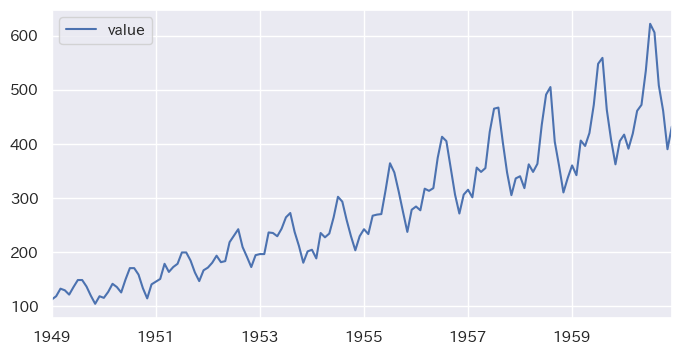

In [13]:
# 時系列折れ線グラフの作成
air_passengers.plot()

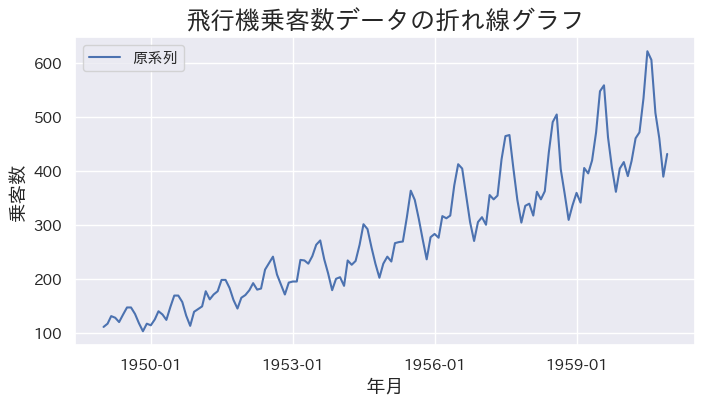

In [14]:
# ================================================
# 飛行機乗客数データの折れ線グラフの描画
# ================================================

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
#   'value' 列に月ごとの乗客数が入っている
ax.plot(air_passengers["value"], label="原系列")

# 軸ラベルとタイトル・凡例
ax.set_xlabel("年月", size=14)  # x軸ラベル
ax.set_ylabel("乗客数", size=14)  # y軸ラベル
ax.set_title("飛行機乗客数データの折れ線グラフ", size=18)  # グラフタイトル
ax.legend()  # 凡例の表示

# ---- x軸（年月）の設定 ----
# 3年ごとに目盛りを表示（1949, 1952, 1955, …）
ax.xaxis.set_major_locator(mdates.YearLocator(3))

# 軸ラベルのフォーマットを「YYYY-MM」に設定
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

In [15]:
# データをコピー（元のデータを壊さないように別の変数に複製する）
air_passengers_lag = air_passengers.copy()

# 1時点（1か月）前のデータを「lag1」列として追加
# shift(1) は行を下方向に1つずらす → t の行に t-1 の値が入る
# 時系列解析でラグ変数（遅れ変数）を作る典型的な方法
air_passengers_lag["lag1"] = air_passengers_lag["value"].shift(1)

# 結果の確認（最初の3行）
# → 先頭行には1つ前のデータが存在しないので NaN が入る
print(air_passengers_lag.head(3))

# 結果の確認（最後の3行）
# → 最後の行には1つ先のデータがないので value のみ表示され、lag1 は1つ前の値になる
print(air_passengers_lag.tail(3))

            value   lag1
1949-01-01    112    NaN
1949-02-01    118  112.0
1949-03-01    132  118.0
            value   lag1
1960-10-01    461  508.0
1960-11-01    390  461.0
1960-12-01    432  390.0


In [16]:
# 2時点前のデータを「lag2」列として追加
# shift(2) → t の行に t-2 の値が入る
# つまり2か月前の乗客数を特徴量として作成
air_passengers_lag["lag2"] = air_passengers_lag["value"].shift(2)

# 逆に未来のデータを参照する例として「lead1」列を追加
# shift(-1) → t の行に t+1 の値が入る
# つまり1か月後の乗客数を列として作成（通常は分析では使わないが確認用）
air_passengers_lag["lead1"] = air_passengers_lag["value"].shift(-1)

# 結果の確認（最初の3行）
# → lag2 は最初の2行が NaN, lead1 は未来が存在しないので最後の行が NaN
print(air_passengers_lag.head(3))

# 結果の確認（最後の3行）
# → lag1, lag2 は直前や2つ前の値が入る
# → lead1 は最後の行が NaN になる
print(air_passengers_lag.tail(3))

            value   lag1   lag2  lead1
1949-01-01    112    NaN    NaN  118.0
1949-02-01    118  112.0    NaN  132.0
1949-03-01    132  118.0  112.0  129.0
            value   lag1   lag2  lead1
1960-10-01    461  508.0  606.0  390.0
1960-11-01    390  461.0  508.0  432.0
1960-12-01    432  390.0  461.0    NaN
